# Graph-ISS

### 0. Specify source code paths and create results folder (if not exists already)

In [16]:
import os, sys

n_threads = 5 # Intra tile parallelization, each imaging round running on a different thread
graph_iss_path = "" # Enter absolute path to graph-ISS repository
prePro_path = graph_iss_path+"/prePro_pipeline/"
graph_decoding_path = graph_iss_path+"/pgm_pipeline/"

dataset_folder = "" # Enter absolute path to dataset folder
tagList_path = "" # Enter absolute path to tagList
tagList = pd.read_csv(tagList_path, sep = ",", usecols = [0,1], header = None, names = ["Seq","Gene"])

results_folder = "" # Enter absolute path to execution folder
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

### 1. Create array of intput images
The dataset folder should have the following data structure:
```
dataset_folder
├── Base1 (1st imaging round)
│   ├── chan0.tif (general stain/anchor channel)
│   ├── chan1.tif (nuclei channels/DAPI)
│   ├── chan2.tif (T channel)
│   ├── chan3.tif (G channel)
│   ├── chan4.tif (C channel)
│   └── chan5.tif (A channel)
├── Base2 (2nd imaging round)
│   ├── chan0.tif (general stain/anchor channel)
│   ├── chan1.tif (nuclei channels/DAPI)
│   ├── chan2.tif (T channel)
│   ├── chan3.tif (G channel)
│   ├── chan4.tif (C channel)
│   └── chan5.tif (A channel)
├── Base3 (3rd imaging round)
│   ├── chan0.tif (general stain/anchor channel)
│   ├── chan1.tif (nuclei channels/DAPI)
│   ├── chan2.tif (T channel)
│   ├── chan3.tif (G channel)
│   ├── chan4.tif (C channel)
│   └── chan5.tif (A channel)
├── Base4 (4th imaging round)
│   ├── chan0.tif (general stain/anchor channel)
│   ├── chan1.tif (nuclei channels/DAPI)
│   ├── chan2.tif (T channel)
│   ├── chan3.tif (G channel)
│   ├── chan4.tif (C channel)
│   └── chan5.tif (A channel)
└── BaseN (n imaging round)
    ├── chan0.tif (general stain/anchor channel)
    ├── chan1.tif (nuclei channels/DAPI)
    ├── chan2.tif (T channel)
    ├── chan3.tif (G channel)
    ├── chan4.tif (C channel)
    └── chan5.tif (A channel)
```

In [2]:
import pandas as pd
import numpy as np

tif_files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_folder):
    for file in f:
        if '.tif' in file:
            tif_files.append(os.path.join(r, file))
            
tif_files.sort()

img_CSV = results_folder+'img_CSV/'
# save into file
if not os.path.exists(img_CSV):
    os.makedirs(img_CSV)
    
    pd.DataFrame({"Key":np.arange(len(tif_files)), "File":tif_files}).to_csv(img_CSV+'/out.csv', index=False, header=True, sep='\t')

### 2. Estimate normalization values for each image

In [3]:
""" norm.py
Compute normalization intervals for each channel and round.
    
    Parameters
    ----------
    sys.argv[1] : input csv file contaning an array of input images
    sys.argv[2] : upper percentile value of 98th percentile distri-
        bution of image patches for signal level estimation.
    sys.argv[3] : number of running threads. Each thread run over 
        an image.
    sys.argv[4] : output csv file where to store computed intervals
    sys.argv[5] : number of random patches used to estimate norma-
        lization intervals
"""

norm_folder = results_folder+"norm/"

if not os.path.exists(norm_folder):
    os.makedirs(norm_folder)
    
    %%capture log
    %run $prePro_path'/norm.py' $img_CSV'/out.csv' 99 $n_threads $norm_folder'/out.h5' 50000
    %store log.stderr > $norm_folder'log_strerr'
    %store log.stdout > $norm_folder'log_stdout'

### 3. Register whole slides

In [4]:
""" mainReg.py
Coarse registration.

    Parameters
    ----------
    sys.argv[1] : Path to pre-processing library
    sys.argv[2] : Output folder where to store aligned images
    sys.argv[3] : Input csv file contaning an array of input images
    sys.argv[4] : Number of resolution levels used for registration
    sys.argv[5] : Type of registration (valid arguments: "translati-
        on", "rigid", or "affine")
    sys.argv[6] : String flag that enables sequencing rounds registra-
        tion using maximum projected images of general stain and
        nuclei channel if enabled. Genaral stain images only are used
        if disabled. (valid arguments: "Nuclei": feature enabled,
        other string: feature disabled)
    sys.argv[7] : Type of registration procedure. (valid arguments:
        "DO1" : if only the general stain of the first sequencing round
        is available
        "DO" : if a general stain image is available for each sequencing
        round
    sys.argv[8] : highest resolution level for multiresolution image reg-
        istration
    sys.argv[9] : lower resolution level for multiresolution image regi-
        stration
    sys.argv[10] : flag to enable BSpline registration after rigid
"""

registration_folder = results_folder+"registration/"

if not os.path.exists(registration_folder):
    os.makedirs(registration_folder)
    os.makedirs(registration_folder+'/folder1')
    
    # Redirect stdout, stderr to file
    f_out =open(registration_folder+'/log_strout','w')
    f_err =open(registration_folder+'/log_strerr','w')
    orig_stdout = sys.stdout
    orig_stderr = sys.stderr
    sys.stdout = f_out
    sys.stderr = f_err
    # Run registration
    %run $prePro_path'/mainReg.py' $prePro_path $registration_folder'/folder1' $img_CSV'/out.csv' 8 'translation,rigid' 'Nuclei' 'DO' 512 4 'noBspline'
    # Close log files
    f_out.close()
    f_err.close()
    # Restore stdout, stderr
    sys.stdout = orig_stdout
    sys.stderr = orig_stderr

### Initialize ipython cluster

In [5]:
import ipyparallel as ipp
rc = ipp.Client(profile='slurm')
rc[:].push(dict(prePro_path=prePro_path, graph_decoding_path=graph_decoding_path, results_folder=results_folder, norm_folder=norm_folder, n_threads=n_threads, tagList=tagList))
rc.ids

[0, 1, 2, 3]

In [6]:
# Progress bar
import sys
import time
import ipyparallel
import ipywidgets
from IPython.display import clear_output, display

def progress_bar(ar):
    # We create a progress bar.
    w = ipywidgets.IntProgress()
    # The maximum value is the number of tasks.
    w.max = len(ar.msg_ids)
    label = ipywidgets.HTML()
    box = ipywidgets.VBox(children=[label, w])
    # We display the widget in the output area.
    display(box)
    # Repeat:
    while not ar.ready():
        # Update the widget's value with the
        # number of tasks that have finished
        # so far.
        w.value = ar.progress
        label.value = u'{index} / {size}'.format(
                        index=ar.progress,
                        size=len(ar)
                    )
    w.value = w.max

### 4. Image tiling

In [7]:
tile_size_x = 1024
tile_size_y = 1024

alltiles = results_folder + "alltiles/"
register_tiles = alltiles + "registered/"

rc[:].push(dict(alltiles=alltiles, registration_folder=registration_folder, register_tiles=register_tiles, tile_size_x=tile_size_x, tile_size_y=tile_size_y))

<AsyncResult: _push>

In [8]:
def runTiling(reg_tif):
    import os
    import sys
    
    reg_tif_name = os.path.splitext(reg_tif)[0]
    os.makedirs(register_tiles+reg_tif_name)
    
    # Redirect stdout, stderr to file
    f_out =open(register_tiles+reg_tif_name+'/log_strout','w')
    f_err =open(register_tiles+reg_tif_name+'/log_strerr','w')
    orig_stdout = sys.stdout
    orig_stderr = sys.stderr
    sys.stdout = f_out
    sys.stderr = f_err
    # Run bioformat command line tool bfconvert
    !bfconvert -tilex $tile_size_x -tiley $tile_size_y $registration_folder'/folder1/'$reg_tif $register_tiles$reg_tif_name/%x_%y.tif    
    # Close log files
    f_out.close()
    f_err.close()
    # Restore stdout, stderr
    sys.stdout = orig_stdout
    sys.stderr = orig_stderr
    
    return 0

if not os.path.exists(alltiles):
    os.makedirs(alltiles)
    if not os.path.exists(register_tiles):
        os.makedirs(register_tiles)
            
        # Run parallel
        view =  rc.load_balanced_view()
        reg_tifs = os.listdir(registration_folder+'/folder1')
        ar = view.map(runTiling, reg_tifs)
        progress_bar(ar)            

### 5. Tiles processing

In [ ]:
def runTiles(tile_tif):
    import sys
    import os
    import glob
    import pandas as pd    
    tile = os.path.splitext(tile_tif)[0]
    # Collect tile channels and rounds
    if not os.path.exists(alltiles+tile):
        os.makedirs(alltiles+tile)
        tifs = glob.glob(register_tiles+'/*/'+tile_tif)
        tifs.sort()
        pd.DataFrame({'Key':[tile]*len(tifs), "File":tifs}).to_csv(alltiles+tile+'/out.csv', index=False, header=True, sep='\t')
            
        
    # Run pre-processing
    prePro_folder = results_folder+tile+'_prePro/'
    if not os.path.exists(prePro_folder):
        os.makedirs(prePro_folder)
        os.makedirs(prePro_folder+"/folder1")
        
        """ main.py
            Performs tile registration, tile normalization using
            precomputed values, tophat filtering, signal candida
            -te detection and signal merging.

            Parameters
            ----------
            sys.argv[1] : Path to pre-processing library
            sys.argv[2] : Input csv file contaning an array of in-
                put images
            sys.argv[3] : Output folder where to store aligned im-
                ages
            sys.argv[4] : Output dataframe of signal candidate dete-
                ction after merging
            sys.argv[5] : Output dataframe of signal candidate dete-
                ction before merging
            sys.argv[6] : Number of thread used for parallelizing
                sequencing rounds
            sys.argv[7] : h maxima threshold
            sys.argv[8] : csv file containing image normalization
                intervals
            sys.argv[9] : Output hdf5 object storing normalized im-
                ages
            sys.argv[10] : Output hdf5 object storing signal candi-
                dates binary masks
            sys.argv[11] : Type of registration procedure. (valid
                arguments: "DO1" : if only the general stain of
                the first sequencing round is available, "DO" : if
                a general stain image is available for each sequen-
                cing round
        """
        tile_path = alltiles+tile+'/out.csv'
        
        # Redirect stdout, stderr to file
        f_out =open(prePro_folder+'/log_strout','w')
        f_err =open(prePro_folder+'/log_strerr','w')
        orig_stdout = sys.stdout
        orig_stderr = sys.stderr
        sys.stdout = f_out
        sys.stderr = f_err
        # Run prePro
        %run $prePro_path'/main.py' $prePro_path $tile_path $prePro_folder"/folder1" $prePro_folder"/out1" $prePro_folder"/out2" $n_threads 0.05 $norm_folder'/out.h5' $prePro_folder"/out3" $prePro_folder"/candidates_max.h5" "DO"
        # Close log files
        f_out.close()
        f_err.close()
        # Restore stdout, stderr
        sys.stdout = orig_stdout
        sys.stderr = orig_stderr
        
    # Predict probabilities of signal candidate detections
    predProb_folder = results_folder+tile+'_predProb/'
    if not os.path.exists(predProb_folder):
        os.makedirs(predProb_folder)
        
        """ get_proba_DNN.py
            Signal candidate probability predictions.

            Parameters
            ----------
            sys.argv[1] : Path to signal probability prediction library
            sys.argv[2] : Input dataframe of signal candidate detection
                after merging
            sys.argv[3] : Output dataframe of signal probability predictions
            sys.argv[4] : (Optional) probability threshold for signal candid-
                    date predictions
        """
        # Redirect stdout, stderr to file
        f_out =open(predProb_folder+'/log_strout','w')
        f_err =open(predProb_folder+'/log_strerr','w')
        orig_stdout = sys.stdout
        orig_stderr = sys.stderr
        sys.stdout = f_out
        sys.stderr = f_err
        %run $prePro_path'/network/get_proba_DNN.py' $prePro_path'/network' $prePro_folder"/out1" $predProb_folder"/out1"
        # Close log files
        f_out.close()
        f_err.close()
        # Restore stdout, stderr
        sys.stdout = orig_stdout
        sys.stderr = orig_stderr
    
    
    # Graph-based decoding
    GM_folder = results_folder+tile+'_GM/'
    if not os.path.exists(GM_folder):
        os.makedirs(GM_folder)

        """ main.py
            Graph-based decoding of signal candidates.

            Parameters
            ----------
            sys.argv[1] : Path to decoding library
            sys.argv[2] : Dataframe of signal probability predictions
            sys.argv[3] : Output file stroring dataframe of decoded
                barcodes
            sys.argv[4] : Output csv file of decoded barcodes
            sys.argv[5] : Number of threads for parallelization
            sys.argv[6] : d_th parameter for building graph connected
                components
            sys.argv[7] : d_max parameter for building graph connected
                components
            sys.argv[8] : Output list of sets of signals detections contribu-
                ting to decoded barcodes
            sys.argv[9] : enable barcodes decoding guided by the list
                of targeted barcodes (valid arguments, "prior": feature
                enabled, other string: feature disabled)
            sys.argv[10] : csv file of targeted barcode sequences
            sys.argv[11] : Dataframe of signal candidate detection befo-
                re merging
            sys.argv[12] : hdf5 object storing normalized images
            sys.argv[13] : Path to signal probability prediction library
        """
        # Redirect stdout, stderr to file
        f_out =open(GM_folder+'/log_strout','w')
        f_err =open(GM_folder+'/log_strerr','w')
        orig_stdout = sys.stdout
        orig_stderr = sys.stderr
        sys.stdout = f_out
        sys.stderr = f_err
        %run $graph_decoding_path'/main.py' $graph_decoding_path $predProb_folder"/out1" $GM_folder'/out2' $GM_folder'/out1' $n_threads 3 4 $GM_folder'/out3' blind $tagList $prePro_folder"/out2" $prePro_folder"/out3" $prePro_path'/network'
        # Close log files
        f_out.close()
        f_err.close()
        # Restore stdout, stderr
        sys.stdout = orig_stdout
        sys.stderr = orig_stderr
        
    # Add tile offset to decoded barcode coordinates
    barcodes_folder = results_folder+'/barcodes/'
    if not os.path.exists(barcodes_folder):
        os.makedirs(barcodes_folder)

    df = pd.read_csv(GM_folder+'/out1')
    x, y = tile.split('_')
    df.loc[:,'global_X_pos'] = df.loc[:,'global_X_pos'] + int(x) * tile_size_x
    df.loc[:,'global_Y_pos'] = df.loc[:,'global_Y_pos'] + int(y) * tile_size_y
    df.to_csv(barcodes_folder+tile+'_barcodes_withOffset.csv', index=False, header=True, sep=',')
    return 0
        
# Run parallel
view =  rc.load_balanced_view()
tiles = os.listdir(register_tiles+os.listdir(register_tiles)[0])
ar = view.map(runTiles, tiles)
progress_bar(ar)

### 6. Output file (barcodes)

In [21]:
from tqdm.notebook import tqdm
# Concatenate results in a single file
barcodes_folder = results_folder+'/barcodes/'

for i, tile_barcodes in enumerate(tqdm(os.listdir(barcodes_folder))):
    if i==0:
        barcodes_df = pd.read_csv(barcodes_folder+tile_barcodes)
    else:
        df = pd.read_csv(barcodes_folder+tile_barcodes)
        barcodes_df = pd.concat([barcodes_df, df])

# Add corresponding gene names to decoded barcodes
d = pd.Series(tagList.Gene.values,index=tagList.Seq).to_dict()
barcodes_df["Gene"] = barcodes_df['letters'].map(d)   

In [27]:
# Auxiliary function for computing final quality score of decoded barcodes
from sklearn.metrics import auc

def runROC(exp_df,unexp_df):
    ppv = []
    tnr = []
    tpr = []
    fpr = []
    n_bins = 100
    fp_minQ = unexp_df.Q.min()
    fp_maxQ = unexp_df.Q.max()
    tp_minQ = exp_df.Q.min()
    tp_maxQ = exp_df.Q.max()
    Q_min = np.amin([fp_minQ,tp_minQ])
    Q_max = np.amax([fp_maxQ,tp_maxQ])
    step = (Q_max-Q_min)/n_bins
    Q=Q_min
    for n in range(n_bins):
        tp = len(exp_df[exp_df.Q>=Q])
        fp = len(unexp_df[unexp_df.Q>=Q])
        tn = len(unexp_df[unexp_df.Q<Q])
        fn = len(exp_df[exp_df.Q<Q])
        ppv.append(tp/(tp+fp))
        tnr.append(tn/(tn+fp))
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))
        Q = Q + step
    return fpr, tpr, auc(fpr, tpr)

# Find best quality threshold that miximize expected vs unexpected separation
def find_d1_param(barcodes_df, tagList_df):
    r = np.linspace(2,5,20) # 20 linearly spaced numbers
    auc_list=[]
    for v in tqdm(r):
        def T_quality(x):
            return np.clip(1-np.log(1+x)/v,0,1)
        barcodes_df["Q"]=barcodes_df.seq_quality_min*barcodes_df.max_dist.apply(T_quality)

        exp_df = barcodes_df[barcodes_df.letters.isin(tagList_df.Seq)]
        unexp_df = barcodes_df[~barcodes_df.letters.isin(tagList_df.Seq)]
        unexp_tagList = unexp_df.letters.unique()
        auc_list.append(runROC(exp_df,unexp_df)[-1])

    return r[np.argmax(auc_list)]

In [28]:
d1 = find_d1_param(barcodes_df,tagList)

In [29]:
def compute_quality(x):
    return np.clip(1-np.log(1+x)/d1,0,1)
barcodes_df["quality"]=barcodes_df.seq_quality_min*barcodes_df.max_dist.apply(compute_quality)

In [30]:
# Save barcode file
barcodes_df.to_csv(results_folder+'/barcodes.csv', index=False, header=True, sep=',')

# Plot quality of decoded barcodes

Text(0, 0.5, 'Number of reads')

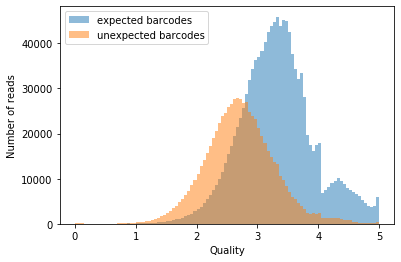

In [32]:
from matplotlib import pyplot as plt

exp_df = barcodes_df[barcodes_df.letters.isin(tagList.Seq)]
unexp_df = barcodes_df[~barcodes_df.letters.isin(tagList.Seq)]

plt.figure()
plt.hist(exp_df.quality,bins=100,alpha=0.5,label='expected barcodes')
plt.hist(unexp_df.quality,bins=100,alpha=0.5,label='unexpected barcodes')
plt.legend()
plt.xlabel("Quality")
plt.ylabel("Number of reads")